# 📘 Module 4: 谁的模型更好？- 模型评估裁判 (The Judge)

## 学习目标 (Learning Objectives)

- 理解NSE、KGE等传统水文评估指标
- 学习信息论指标的含义和应用
- 掌握多维度评估模型性能的方法
- 理解不同指标在不同场景下的适用性

---

## ⚖️ 为什么需要评估指标？

在前面的模块中，我们学习了不同类型的水文模型。但如何判断哪个模型更好？

这就需要一个公正的"裁判"——**评估指标 (Evaluation Metrics)**。

### 一个有趣的问题 🤔

假设有两个模型的预测结果：
- **模型A**：峰值时间准确，但水量总是偏多
- **模型B**：总水量准确，但峰值总是延迟

哪个模型更好？——这取决于你的应用场景！

In [6]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import sys
import os
import warnings

# 添加项目路径
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# 设置绘图参数
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 过滤警告
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='.*ConvergenceWarning.*')

np.random.seed(42)

print("✅ 环境设置完成！")

✅ 环境设置完成！


## 📊 Part 1: 准备演示数据

首先，让我们创建一些模拟场景来理解不同评估指标。

In [7]:
def generate_evaluation_scenarios(n=200):
    """
    生成不同特征的模型预测结果用于演示
    """
    # 创建"真实"观测值
    t = np.arange(n)
    # 基础流量 + 几次洪水事件
    observed = 10 + 5 * np.sin(t / 20)  # 基流变化
    
    # 添加洪水事件
    flood_peaks = [30, 80, 130, 170]
    for peak in flood_peaks:
        observed += 50 * np.exp(-0.1 * np.abs(t - peak))
    
    observed += np.random.normal(0, 1, n)  # 噪声
    observed = np.maximum(0, observed)
    
    # 创建不同特征的模型预测
    predictions = {}
    
    # 模型A: 完美模型（略微加噪声）
    predictions['Perfect'] = observed + np.random.normal(0, 0.5, n)
    
    # 模型B: 峰值准确但偏低
    predictions['Low Bias'] = observed * 0.8 + np.random.normal(0, 1, n)
    
    # 模型C: 时间延迟
    predictions['Time Lag'] = np.roll(observed, 3) + np.random.normal(0, 1, n)
    
    # 模型D: 高变异性（过于敏感）
    predictions['High Var'] = observed + observed * 0.3 * np.random.randn(n)
    
    # 模型E: 平滑（不敏感）
    from scipy.ndimage import uniform_filter1d
    predictions['Smoothed'] = uniform_filter1d(observed, size=10)
    
    # 模型F: 只预测均值（最差模型）
    predictions['Mean Only'] = np.full(n, np.mean(observed))
    
    return observed, predictions

# 生成数据
observed, predictions = generate_evaluation_scenarios(200)
print(f"📊 生成了 6 种不同特征的模型预测")

📊 生成了 6 种不同特征的模型预测


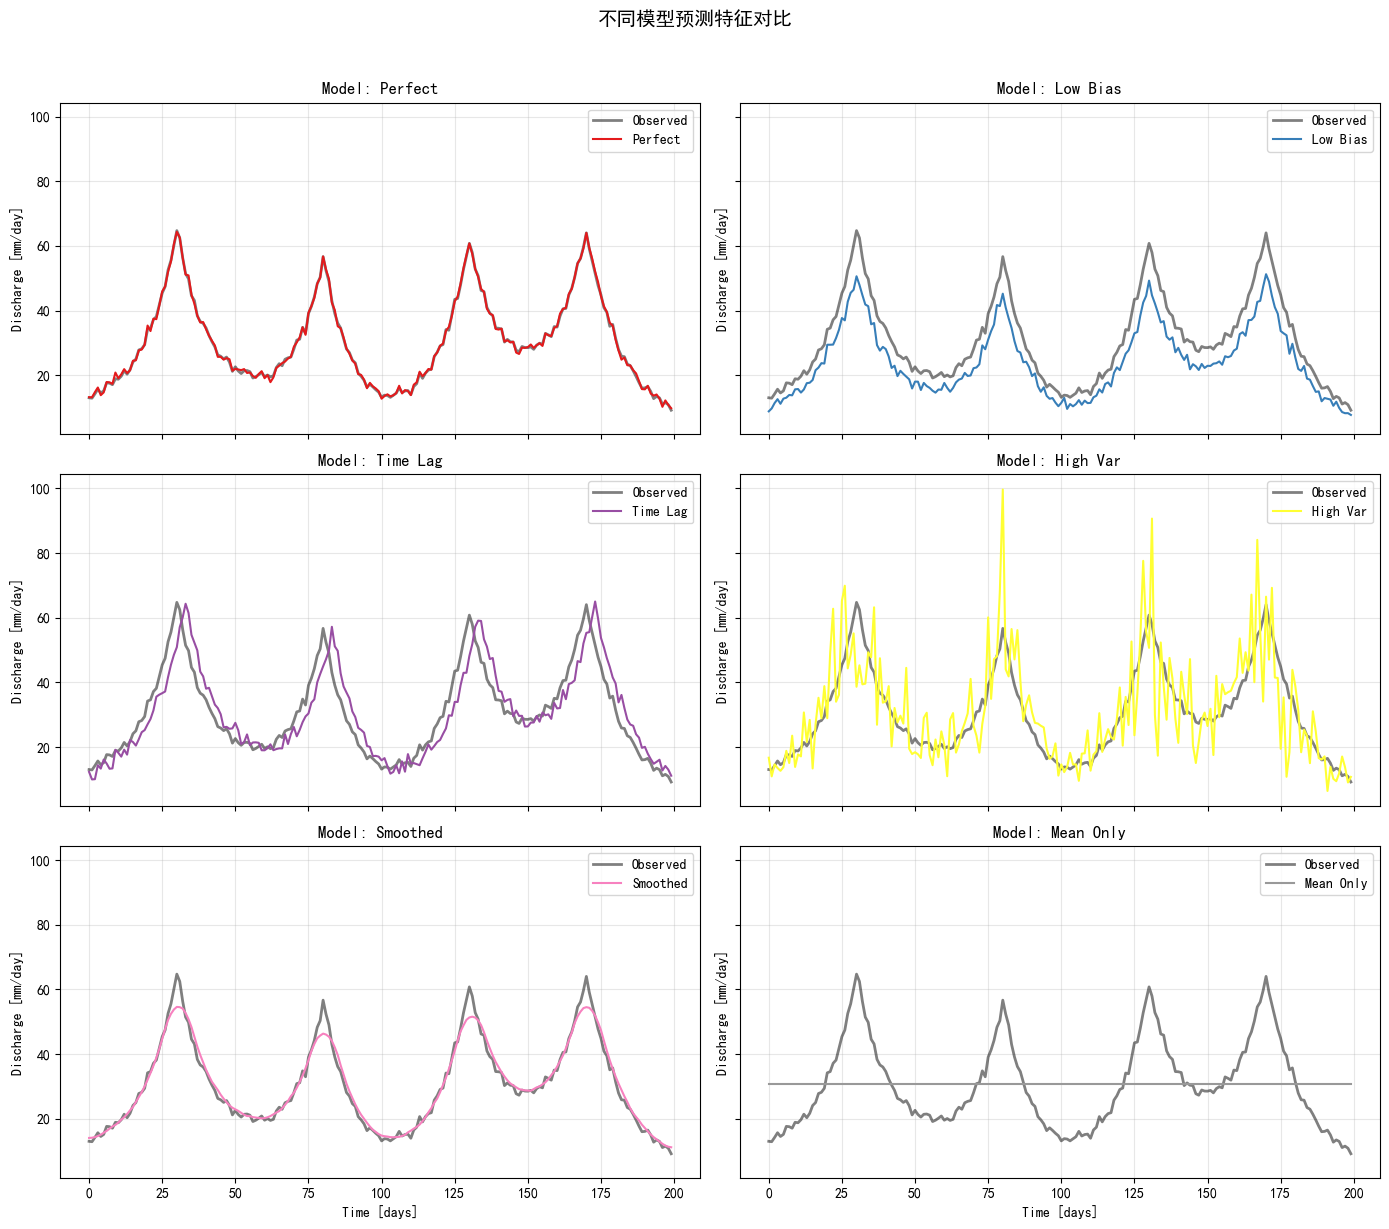

In [8]:
# 可视化不同模型的预测效果
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()

colors = plt.cm.Set1(np.linspace(0, 1, 6))

for idx, (name, pred) in enumerate(predictions.items()):
    ax = axes[idx]
    ax.plot(observed, 'k-', linewidth=2, alpha=0.5, label='Observed')
    ax.plot(pred, '-', color=colors[idx], linewidth=1.5, label=f'{name}')
    ax.set_title(f'Model: {name}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_ylabel('Discharge [mm/day]')
    ax.grid(True, alpha=0.3)

axes[4].set_xlabel('Time [days]')
axes[5].set_xlabel('Time [days]')

plt.suptitle('不同模型预测特征对比', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 📈 Part 2: Nash-Sutcliffe效率系数 (NSE)

### 公式

$$NSE = 1 - \frac{\sum_{t=1}^{n}(Q_{obs}^t - Q_{sim}^t)^2}{\sum_{t=1}^{n}(Q_{obs}^t - \overline{Q_{obs}})^2}$$

### 解释
- **NSE = 1**：完美预测
- **NSE = 0**：模型和观测均值一样好
- **NSE < 0**：模型比使用均值还差

### 特点
- 对**洪峰**非常敏感（因为平方项放大了大误差）
- 是水文学最常用的指标之一

In [9]:
def nse(observed, simulated):
    """
    计算Nash-Sutcliffe效率系数
    """
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - numerator / (denominator + 1e-10)

# 计算所有模型的NSE
print("📊 NSE (Nash-Sutcliffe Efficiency) 评分:\n")
print(f"{'Model':<15} {'NSE':>10} {'Interpretation':<30}")
print("="*55)

nse_scores = {}
for name, pred in predictions.items():
    score = nse(observed, pred)
    nse_scores[name] = score
    
    if score > 0.9:
        interp = "Excellent (优秀)"
    elif score > 0.7:
        interp = "Good (良好)"
    elif score > 0.5:
        interp = "Satisfactory (及格)"
    elif score > 0:
        interp = "Unsatisfactory (不及格)"
    else:
        interp = "Poor - Worse than mean (很差)"
    
    print(f"{name:<15} {score:>10.4f} {interp:<30}")

📊 NSE (Nash-Sutcliffe Efficiency) 评分:

Model                  NSE Interpretation                
Perfect             0.9986 Excellent (优秀)                
Low Bias            0.7396 Good (良好)                     
Time Lag            0.7949 Good (良好)                     
High Var            0.4002 Unsatisfactory (不及格)          
Smoothed            0.9688 Excellent (优秀)                
Mean Only           0.0000 Unsatisfactory (不及格)          


## 📈 Part 3: Kling-Gupta效率系数 (KGE)

### 公式

$$KGE = 1 - \sqrt{(r-1)^2 + (\alpha-1)^2 + (\beta-1)^2}$$

其中：
- **r**：相关系数（时间同步性）
- **α = σ_sim / σ_obs**：变异性比（波动幅度）
- **β = μ_sim / μ_obs**：偏差比（总量准确性）

### 优势
- 分解为三个可解释的组成部分
- 更平衡地考虑不同误差来源
- 比NSE更适合诊断问题

In [10]:
def kge(observed, simulated):
    """
    计算Kling-Gupta效率系数及其组成部分
    """
    # 相关系数
    r = np.corrcoef(observed, simulated)[0, 1]
    
    # 变异性比
    alpha = np.std(simulated) / (np.std(observed) + 1e-10)
    
    # 偏差比
    beta = np.mean(simulated) / (np.mean(observed) + 1e-10)
    
    # KGE
    kge_value = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
    return kge_value, r, alpha, beta

# 计算所有模型的KGE
print("📊 KGE (Kling-Gupta Efficiency) 评分:\n")
print(f"{'Model':<15} {'KGE':>8} {'r':>8} {'α':>8} {'β':>8}")
print("="*50)

kge_results = {}
for name, pred in predictions.items():
    kge_val, r, alpha, beta = kge(observed, pred)
    kge_results[name] = {'KGE': kge_val, 'r': r, 'alpha': alpha, 'beta': beta}
    print(f"{name:<15} {kge_val:>8.4f} {r:>8.4f} {alpha:>8.4f} {beta:>8.4f}")

print("\n📖 解读：")
print("  r = 相关性 (1 = 完美同步)")
print("  α = 变异性比 (1 = 波动幅度一致)")
print("  β = 偏差比 (1 = 总量准确)")

📊 KGE (Kling-Gupta Efficiency) 评分:

Model                KGE        r        α        β
Perfect           0.9983   0.9993   0.9993   1.0014
Low Bias          0.7160   0.9958   0.8013   0.7972
Time Lag          0.8976   0.8976   1.0015   1.0003
High Var          0.6842   0.7760   1.2208   1.0281
Smoothed          0.9181   0.9866   0.9192   1.0002
Mean Only        -0.4142  -0.0000   0.0000   1.0000

📖 解读：
  r = 相关性 (1 = 完美同步)
  α = 变异性比 (1 = 波动幅度一致)
  β = 偏差比 (1 = 总量准确)


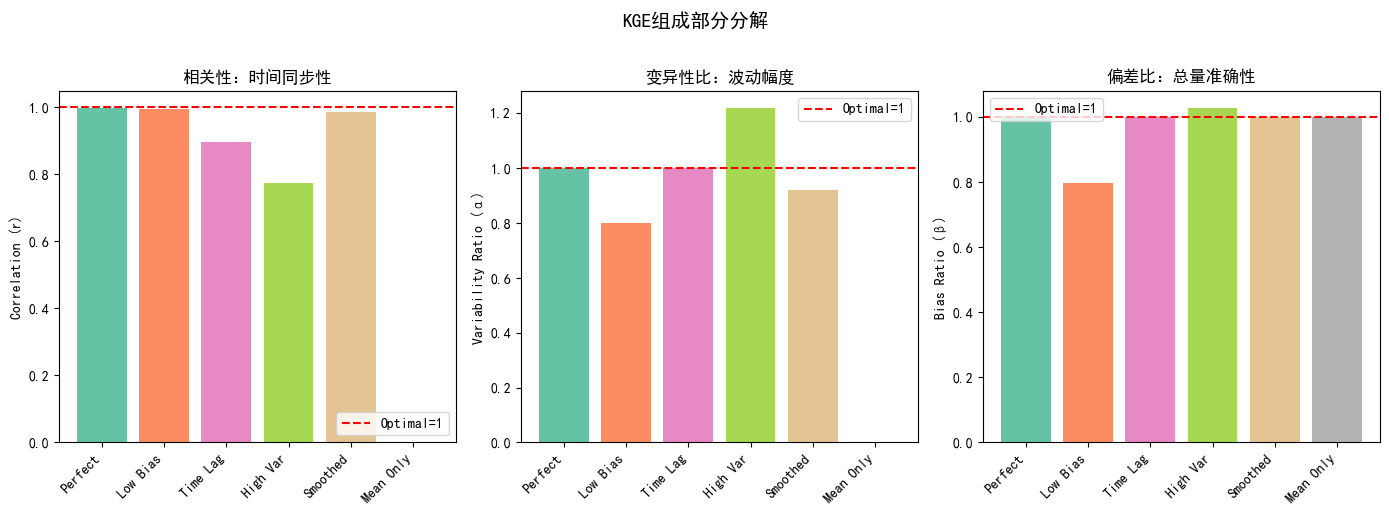

In [11]:
# 可视化KGE分解
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

model_names = list(kge_results.keys())
x_pos = np.arange(len(model_names))
colors_bar = plt.cm.Set2(np.linspace(0, 1, len(model_names)))

# r 值
r_values = [kge_results[m]['r'] for m in model_names]
axes[0].bar(x_pos, r_values, color=colors_bar)
axes[0].axhline(y=1, color='red', linestyle='--', label='Optimal=1')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].set_ylabel('Correlation (r)')
axes[0].set_title('相关性：时间同步性', fontweight='bold')
axes[0].legend()

# α 值
alpha_values = [kge_results[m]['alpha'] for m in model_names]
axes[1].bar(x_pos, alpha_values, color=colors_bar)
axes[1].axhline(y=1, color='red', linestyle='--', label='Optimal=1')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1].set_ylabel('Variability Ratio (α)')
axes[1].set_title('变异性比：波动幅度', fontweight='bold')
axes[1].legend()

# β 值
beta_values = [kge_results[m]['beta'] for m in model_names]
axes[2].bar(x_pos, beta_values, color=colors_bar)
axes[2].axhline(y=1, color='red', linestyle='--', label='Optimal=1')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(model_names, rotation=45, ha='right')
axes[2].set_ylabel('Bias Ratio (β)')
axes[2].set_title('偏差比：总量准确性', fontweight='bold')
axes[2].legend()

plt.suptitle('KGE组成部分分解', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 💡 诊断分析

从KGE分解中我们可以看到：

- **Low Bias模型**：β=0.8 → 系统性低估（总量偏少）
- **Time Lag模型**：r较低 → 时间不同步
- **Smoothed模型**：α<1 → 变异性不足（太平滑）
- **High Var模型**：α>1 → 变异性过大（太敏感）

## 🧮 Part 4: 信息论指标

除了传统指标，信息论提供了另一个视角来评估模型。

### 条件熵 H(Obs|Sim)

**含义**：给定模型预测后，观测值还有多少不确定性？

- **H = 0**：完美预测（没有剩余不确定性）
- **H 越大**：模型提供的信息越少

### 归一化条件熵

$$H_{norm} = \frac{H(Obs|Sim)}{H(Obs)}$$

- **范围 [0, 1]**
- **0 = 完美**
- **1 = 模型没有提供任何信息**

In [12]:
# 导入项目中的熵计算函数
try:
    from src.metrics.entropy import (
        conditional_entropy, 
        normalized_conditional_entropy,
        mutual_information,
        joint_entropy
    )
    print("✅ 成功导入项目中的熵计算模块")
except ImportError:
    print("⚠️ 无法导入项目模块，使用内置实现")
    
    # 简化版实现
    def simple_entropy(data, n_bins=12):
        """计算简单熵"""
        counts, _ = np.histogram(data, bins=n_bins)
        probs = counts / len(data)
        probs = probs[probs > 0]
        return -np.sum(probs * np.log2(probs))
    
    def conditional_entropy(obs, sim, n_bins=12):
        """计算条件熵 H(obs|sim)"""
        # 联合熵
        joint_hist, _, _ = np.histogram2d(obs, sim, bins=n_bins)
        joint_probs = joint_hist / len(obs)
        joint_probs = joint_probs[joint_probs > 0]
        H_joint = -np.sum(joint_probs * np.log2(joint_probs))
        
        # sim的边际熵
        H_sim = simple_entropy(sim, n_bins)
        
        return H_joint - H_sim
    
    def normalized_conditional_entropy(obs, sim, n_bins=12):
        """计算归一化条件熵"""
        H_cond = conditional_entropy(obs, sim, n_bins)
        H_obs = simple_entropy(obs, n_bins)
        return H_cond / (H_obs + 1e-10)
    
    def mutual_information(obs, sim, n_bins=12):
        """计算互信息"""
        H_obs = simple_entropy(obs, n_bins)
        H_cond = conditional_entropy(obs, sim, n_bins)
        return H_obs - H_cond

✅ 成功导入项目中的熵计算模块


In [13]:
# 计算信息论指标
print("📊 信息论指标评分:\n")
print(f"{'Model':<15} {'H_cond':>10} {'H_norm':>10} {'MI':>10}")
print("="*50)

entropy_results = {}
for name, pred in predictions.items():
    h_cond = conditional_entropy(observed, pred)
    h_norm = normalized_conditional_entropy(observed, pred)
    mi = mutual_information(observed, pred)
    
    entropy_results[name] = {'H_cond': h_cond, 'H_norm': h_norm, 'MI': mi}
    print(f"{name:<15} {h_cond:>10.4f} {h_norm:>10.4f} {mi:>10.4f}")

print("\n📖 解读：")
print("  H_cond = 条件熵 (越低越好)")
print("  H_norm = 归一化条件熵 (0=完美, 1=无信息)")
print("  MI = 互信息 (越高越好，表示共享信息量)")

📊 信息论指标评分:

Model               H_cond     H_norm         MI
Perfect             0.2225     0.0637     3.2700
Perfect             0.2225     0.0637     3.2700
Low Bias            0.8697     0.2490     2.6227
Low Bias            0.8697     0.2490     2.6227
Time Lag            1.9320     0.5532     1.5605
Time Lag            1.9320     0.5532     1.5605
High Var            2.4156     0.6917     1.0768
High Var            2.4156     0.6917     1.0768
Smoothed            0.9515     0.2724     2.5410
Smoothed            0.9515     0.2724     2.5410
Mean Only           3.4924     1.0000    -0.0000

📖 解读：
  H_cond = 条件熵 (越低越好)
  H_norm = 归一化条件熵 (0=完美, 1=无信息)
  MI = 互信息 (越高越好，表示共享信息量)
Mean Only           3.4924     1.0000    -0.0000

📖 解读：
  H_cond = 条件熵 (越低越好)
  H_norm = 归一化条件熵 (0=完美, 1=无信息)
  MI = 互信息 (越高越好，表示共享信息量)


## 🎯 Part 5: 直觉陷阱实验

现在让我们做一个实验：看看直觉判断和量化评估是否一致。

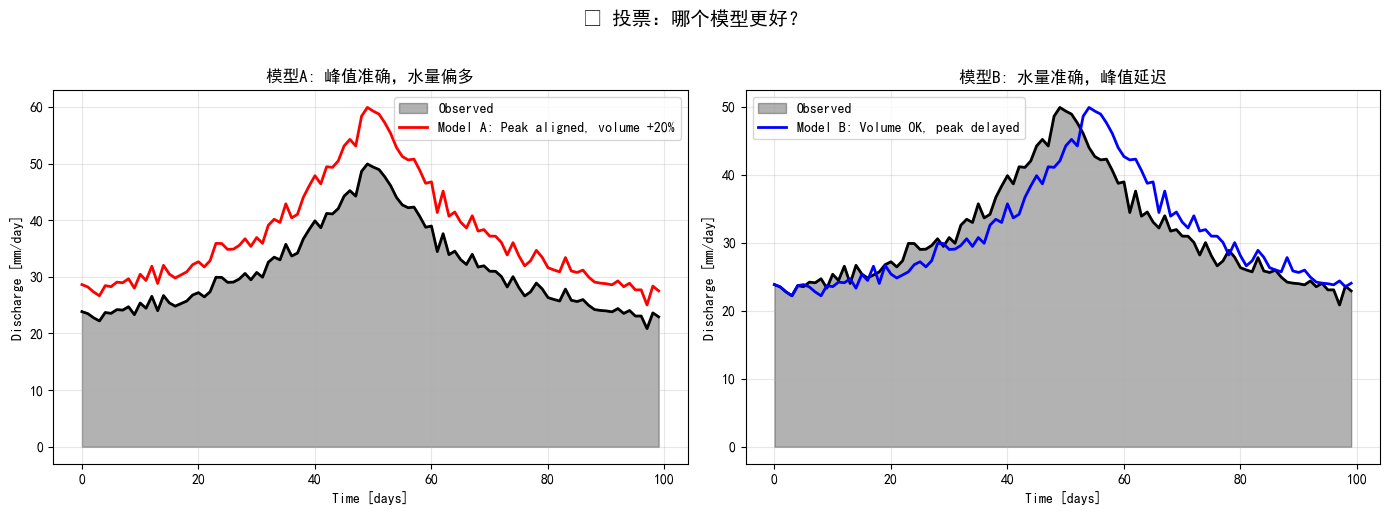

In [14]:
# 创建两个特殊场景
n = 100
t = np.arange(n)

# 真实观测值
obs_special = 20 + 30 * np.exp(-0.05 * np.abs(t - 50))  # 一次洪峰
obs_special += np.random.normal(0, 1, n)

# 模型A: 峰值准确但水量偏多
pred_A = obs_special * 1.2  # 水量偏多20%

# 模型B: 水量准确但峰值延迟
pred_B = np.roll(obs_special, 5)  # 延迟5天
pred_B[:5] = obs_special[:5]  # 处理边界

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].fill_between(t, 0, obs_special, alpha=0.3, color='black', label='Observed')
axes[0].plot(obs_special, 'k-', linewidth=2)
axes[0].plot(pred_A, 'r-', linewidth=2, label='Model A: Peak aligned, volume +20%')
axes[0].set_xlabel('Time [days]')
axes[0].set_ylabel('Discharge [mm/day]')
axes[0].set_title('模型A: 峰值准确，水量偏多', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].fill_between(t, 0, obs_special, alpha=0.3, color='black', label='Observed')
axes[1].plot(obs_special, 'k-', linewidth=2)
axes[1].plot(pred_B, 'b-', linewidth=2, label='Model B: Volume OK, peak delayed')
axes[1].set_xlabel('Time [days]')
axes[1].set_ylabel('Discharge [mm/day]')
axes[1].set_title('模型B: 水量准确，峰值延迟', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('🤔 投票：哪个模型更好？', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# 计算两个模型的所有指标
print("\n📊 模型A vs 模型B 评估对比:\n")

results_compare = pd.DataFrame(index=['Model A (Volume+)', 'Model B (Time Lag)'])

# NSE
results_compare['NSE'] = [nse(obs_special, pred_A), nse(obs_special, pred_B)]

# KGE
kge_A, r_A, alpha_A, beta_A = kge(obs_special, pred_A)
kge_B, r_B, alpha_B, beta_B = kge(obs_special, pred_B)
results_compare['KGE'] = [kge_A, kge_B]
results_compare['r'] = [r_A, r_B]
results_compare['α'] = [alpha_A, alpha_B]
results_compare['β'] = [beta_A, beta_B]

# 熵指标
results_compare['H_norm'] = [
    normalized_conditional_entropy(obs_special, pred_A),
    normalized_conditional_entropy(obs_special, pred_B)
]

# 总水量误差
results_compare['Volume Error %'] = [
    (np.sum(pred_A) - np.sum(obs_special)) / np.sum(obs_special) * 100,
    (np.sum(pred_B) - np.sum(obs_special)) / np.sum(obs_special) * 100
]

print(results_compare.round(4).to_string())

print("\n" + "="*60)
print("💡 分析结论：")
print("="*60)
if results_compare.loc['Model A (Volume+)', 'NSE'] > results_compare.loc['Model B (Time Lag)', 'NSE']:
    print(f"NSE更偏爱: 模型A (因为NSE对时间不同步惩罚更大)")
else:
    print(f"NSE更偏爱: 模型B")
    
print(f"\n模型A问题: β={beta_A:.3f} (偏离1，水量不准)")
print(f"模型B问题: r={r_B:.3f} (相关性降低，时间不同步)")
print("\n👉 结论：没有'最好'的指标，选择取决于应用场景！")


📊 模型A vs 模型B 评估对比:

                       NSE     KGE       r       α       β  H_norm  Volume Error %
Model A (Volume+)   0.2819  0.7172  1.0000  1.2000  1.2000  0.0000         20.0000
Model B (Time Lag)  0.8018  0.9005  0.9005  0.9962  1.0008  0.5262          0.0793

💡 分析结论：
NSE更偏爱: 模型B

模型A问题: β=1.200 (偏离1，水量不准)
模型B问题: r=0.901 (相关性降低，时间不同步)

👉 结论：没有'最好'的指标，选择取决于应用场景！
                       NSE     KGE       r       α       β  H_norm  Volume Error %
Model A (Volume+)   0.2819  0.7172  1.0000  1.2000  1.2000  0.0000         20.0000
Model B (Time Lag)  0.8018  0.9005  0.9005  0.9962  1.0008  0.5262          0.0793

💡 分析结论：
NSE更偏爱: 模型B

模型A问题: β=1.200 (偏离1，水量不准)
模型B问题: r=0.901 (相关性降低，时间不同步)

👉 结论：没有'最好'的指标，选择取决于应用场景！


## 📊 Part 6: 雷达图多维评估

在实际应用中，我们应该综合多个指标来评估模型。雷达图是一个很好的可视化方式。

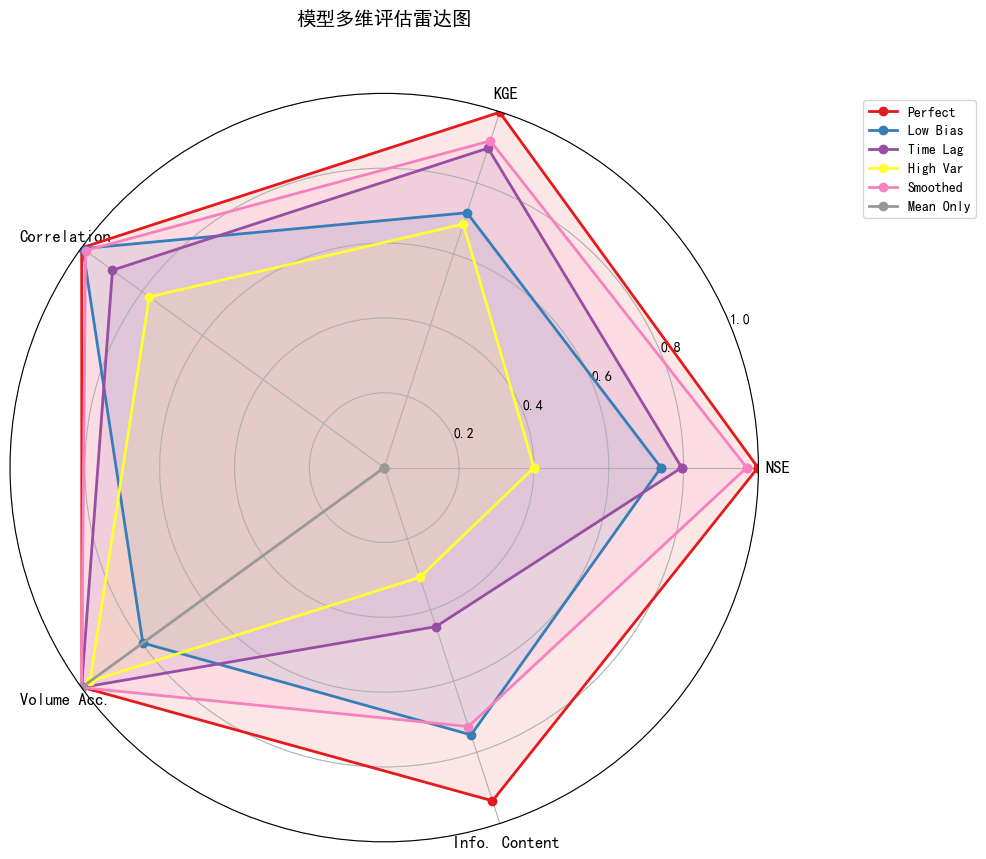

In [16]:
def create_radar_chart(model_scores, title="模型多维评估雷达图"):
    """
    创建雷达图比较多个模型
    
    model_scores: dict, {model_name: {metric_name: score}}
    """
    from matplotlib.patches import Patch
    
    # 指标名称（转换为0-1范围，越大越好）
    metrics = ['NSE', 'KGE', 'Correlation', 'Volume Acc.', 'Info. Content']
    
    # 计算每个模型的得分
    model_data = {}
    for name, pred in predictions.items():
        nse_score = max(0, nse(observed, pred))  # 截断负值
        kge_score, r, alpha, beta = kge(observed, pred)
        kge_score = max(0, kge_score)
        h_norm = normalized_conditional_entropy(observed, pred)
        info_content = max(0, 1 - h_norm)  # 转换为"越大越好"
        volume_acc = 1 - abs(beta - 1)  # 水量准确性
        
        model_data[name] = [nse_score, kge_score, r, volume_acc, info_content]
    
    # 绘制雷达图
    n_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]  # 闭合
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(model_data)))
    
    for (name, scores), color in zip(model_data.items(), colors):
        values = scores + scores[:1]  # 闭合
        ax.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
        ax.fill(angles, values, alpha=0.1, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, size=12)
    ax.set_ylim(0, 1)
    ax.set_title(title, size=14, fontweight='bold', y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

create_radar_chart(predictions)

## 📚 总结

### 评估指标对比表

| 指标 | 范围 | 最优值 | 优点 | 缺点 | 适用场景 |
|------|------|--------|------|------|----------|
| **NSE** | (-∞, 1] | 1 | 广泛使用，易理解 | 对洪峰过于敏感 | 一般水文模拟 |
| **KGE** | (-∞, 1] | 1 | 可分解诊断 | 计算稍复杂 | 需要诊断问题时 |
| **H_norm** | [0, 1] | 0 | 理论基础强 | 需要离散化 | 信息论研究 |

### 选择指标的建议

1. **洪水预报**：重视峰值，用NSE或专门的峰值指标
2. **水资源管理**：重视总量，用β或水量误差
3. **模型诊断**：用KGE分解找问题
4. **科学研究**：多指标综合评估

### 本模块学到了什么？

1. **NSE的计算和解读**
2. **KGE的优势和三个组成部分**
3. **信息论指标的含义**
4. **没有万能的指标，要根据场景选择**

---

## 🎓 恭喜完成本教程！

通过这四个模块，你已经学习了：
1. 水文循环的基本原理和简单模型
2. 物理模型（HBV）的结构和参数
3. 数据驱动模型（LSTM）的工作原理
4. 如何科学地评估模型性能

现在你已经具备了理解和使用本项目代码的基础知识！